In [19]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
import itertools
%matplotlib inline
sns.set()

In [20]:
data_sample = pd.read_csv('20171016-210106-DataSample.csv',dtype={"value": float})
data_sample2 = pd.read_csv('20171016-210304-DataSample.csv',dtype={"value": float})
data_sample3 = pd.read_csv('20171016-210529-DataSample.csv',dtype={"value": float})
data_sample4 = pd.read_csv('20171016-235959-DataSample.csv',dtype={"value": float})

data_sample = data_sample.append([data_sample2,data_sample3,data_sample4])
data_sample['startDate'] = pd.to_datetime(data_sample['startDate']) 
data_sample['owner'].replace('00000000-5854-8d6f-b8eb-cf14a0f795df','00000000-56ff-538b-2223-e1800b5e3ddb',inplace=True)
data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])
data_sample['endDate'] = pd.to_datetime(data_sample['endDate'])


to_tdelta = lambda row: row['endDate'] - row['startDate']
data_sample['duration'] = data_sample.apply(to_tdelta, axis=1)
data_sample['day_of_week'] = data_sample['startDate'].dt.dayofweek
data_sample.head() #0 - 6 is monday - sunday 
data_sample['owner'].unique()

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['00000000-56ff-538b-2223-e1800b5e3ddb',
       '00000000-5851-ee08-eb34-e20acc5af74e',
       'd145b032-b7a5-4fa8-9887-b46598f4683a',
       '00000000-5951-4787-2497-ae32dc8d07d4',
       '00000000-584e-1f39-bdee-d4102b989d01',
       '00000000-584d-a4f0-bdee-d4102b989ce5'], dtype=object)

In [5]:
x1 = data_sample.type
x2 = data_sample.value

types = ['health-bmi','health-body-fat','health-weight', 'health-step-count']


In [6]:
def prepare_table(x, y,time='D',data_sample=data_sample):
    steps = data_sample[data_sample['type'] == x]
    bodyfat = data_sample[data_sample['type'] == y]


    steps.index = steps['startDate']
    bodyfat.index = bodyfat['startDate']


    steps['value'] = pd.to_numeric(steps['value'])
    steps = steps.loc[:,'value']
    if x == 'health-step-count':
        steps = steps.resample(time).sum()
    else:
        steps = steps.resample(time).mean()


    bodyfat['value'] = pd.to_numeric(bodyfat['value'])
    bodyfat = bodyfat.loc[:,'value']
    bodyfat = bodyfat.resample(time).mean()

    steps = steps.to_frame('first')
    steps['second'] = bodyfat
    
    return steps

In [7]:
def plotter(steps):
    steps = steps.dropna()
    x = steps['first'].values
    y = steps['second'].values
    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black')
    plt.plot(x, regr.predict(x), color='yellow', linewidth=2)
    
    corr_info = stats.stats.pearsonr(x, y)
    r = corr_info[0][0]
    p = corr_info[1][0]
    return r, p


In [8]:
users = data_sample['owner'].unique()
users

array(['00000000-56ff-538b-2223-e1800b5e3ddb',
       '00000000-5851-ee08-eb34-e20acc5af74e',
       '00000000-584e-1f39-bdee-d4102b989d01',
       '00000000-584d-a4f0-bdee-d4102b989ce5'], dtype=object)

In [11]:
bmi = data_sample[data_sample['type'] == 'health-bmi']
bmi.index = bmi['startDate']
bmi['value'] = pd.Series(bmi['value']).convert_objects(convert_numeric=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


           value
count  38.000000
mean   26.657827
std     0.519584
min    25.671272
25%    26.196478
50%    26.691365
75%    27.061039
max    27.867441
           value
count  48.000000
mean   26.615515
std     0.477032
min    25.331828
25%    26.268160
50%    26.680382
75%    26.991077
max    27.469895


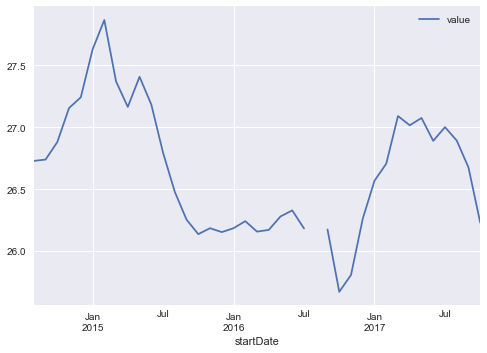

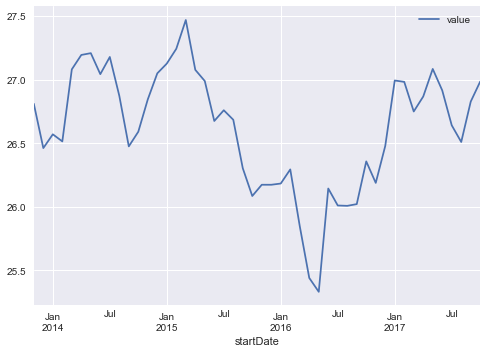

In [12]:
# BMI by month over the whole period
bmi_means = {}
for owner in bmi['owner'].unique():
    data_by_owner = bmi[bmi['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean()
    resampled_data.plot()
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']
    bmi_means[owner] = mean
    

In [13]:
for owner in bmi_means:
    print('Owner {} has monthly BMI mean of {}'.format(owner, bmi_means[owner]))

Owner 00000000-56ff-538b-2223-e1800b5e3ddb has monthly BMI mean of 26.6578270652
Owner 00000000-5851-ee08-eb34-e20acc5af74e has monthly BMI mean of 26.6155145882


           value
count  37.000000
mean   -0.000469
std     0.009063
min    -0.019238
25%    -0.006827
50%     0.000529
75%     0.005176
max     0.017613
           value
count  47.000000
mean    0.000190
std     0.010247
min    -0.016982
25%    -0.006328
50%     0.000372
75%     0.004706
max     0.032079


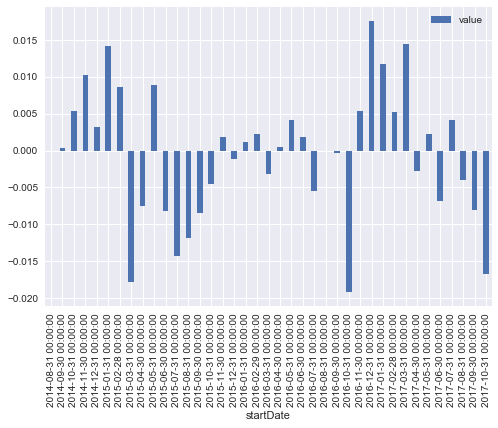

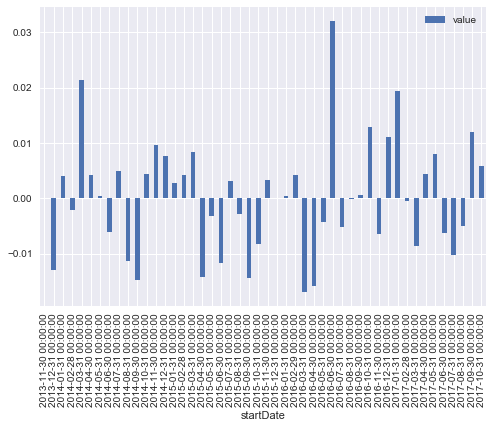

In [14]:
# pct_change slope comparison of each bmi
for owner in bmi['owner'].unique():
    data_by_owner = bmi[bmi['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean().pct_change()
    resampled_data.plot(kind='bar')
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']

In [15]:
weight = data_sample[data_sample['type'] == 'health-weight']
weight.index = weight['startDate']
weight['value'] = pd.Series(weight['value']).convert_objects(convert_numeric=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


           value
count  38.000000
mean   70.823191
std     1.381109
min    68.206003
25%    69.591991
50%    70.889640
75%    71.898472
max    74.041000
           value
count  48.000000
mean   86.234726
std     1.546358
min    82.075116
25%    85.108831
50%    86.444434
75%    87.453987
max    89.002454
           value
count  12.000000
mean   71.574003
std     3.471932
min    66.700759
25%    68.837036
50%    70.465419
75%    74.959217
max    76.257950
           value
count   1.000000
mean   54.431084
std          NaN
min    54.431084
25%    54.431084
50%    54.431084
75%    54.431084
max    54.431084


C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=551.0, right=551.0
  'left=%s, right=%s') % (left, right))


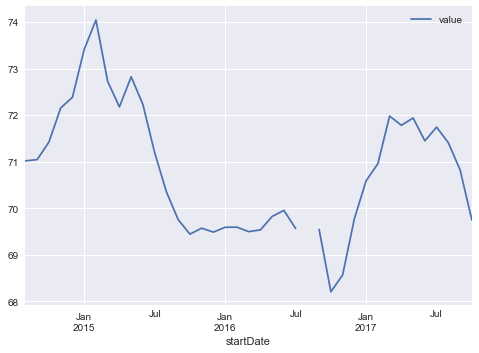

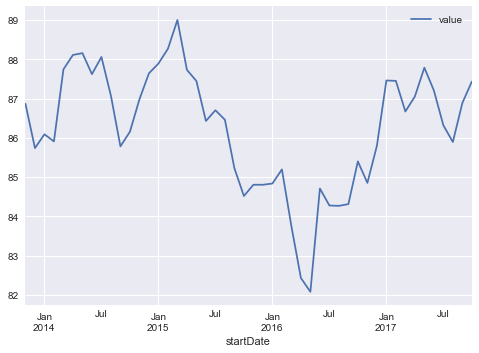

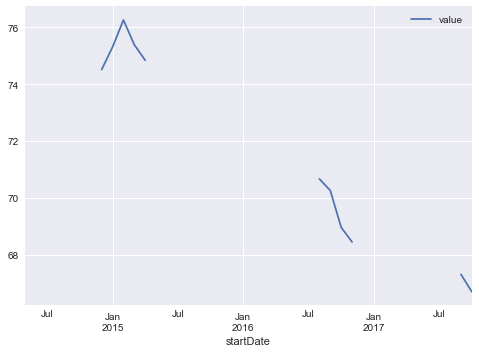

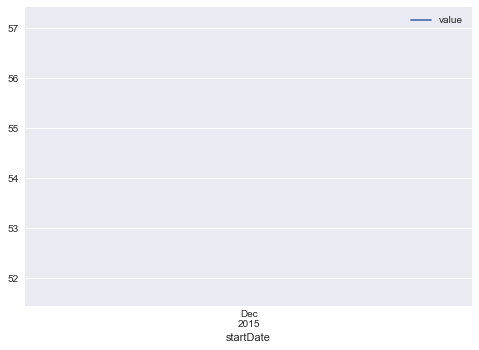

In [16]:
#weight over time
weight_info = {}
for owner in weight['owner'].unique():
    data_by_owner = weight[weight['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean()
    resampled_data.plot()
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']
    min_ = data_by_owner.describe().loc['min', 'value']
    max_ = data_by_owner.describe().loc['max', 'value']
    weight_info[owner] = {'mean': mean, 'min': min_, 'max': max_}

In [17]:
# weight with means, mins, and maxs
for owner in weight_info:
    print('Owner {} has monthly weight mean of {}, min of {}, max of {}'.format(owner, weight_info[owner]['mean'],  weight_info[owner]['min'],  weight_info[owner]['max']))

Owner 00000000-584d-a4f0-bdee-d4102b989ce5 has monthly weight mean of 71.5740032601, min of 65.997689835, max of 77.56429527
Owner 00000000-56ff-538b-2223-e1800b5e3ddb has monthly weight mean of 70.8231914399, min of 67.0790023804, max of 77.2030029297
Owner 00000000-5851-ee08-eb34-e20acc5af74e has monthly weight mean of 86.2347262945, min of 80.3640060425, max of 90.9640045166
Owner 00000000-584e-1f39-bdee-d4102b989d01 has monthly weight mean of 54.4310844, min of 54.4310844, max of 54.4310844


In [18]:

# biggest change in a month period
for owner in weight_info:
    #print "Owner {}: ".format(owner)
    a = weight[weight['owner'] == owner].groupby(pd.TimeGrouper("M"))
    print("\nNEXT USER\n")
    for i, j in a:
        #j = j.dropna(axis = 1, how = 'all')
        maxi = j.max()
        mini = j.min()
        try:
            diff = j.max()['value'] - j.min()['value']
            print ("Weight change in the month of {} for user {} is {}".format(maxi['startDate'], owner, diff))
        except(KeyError):
            None
    #plt.plot(a)
    #plt.show()


NEXT USER

Weight change in the month of 2014-05-28 08:50:00 for user 00000000-584d-a4f0-bdee-d4102b989ce5 is 0.0
Weight change in the month of nan for user 00000000-584d-a4f0-bdee-d4102b989ce5 is nan
Weight change in the month of nan for user 00000000-584d-a4f0-bdee-d4102b989ce5 is nan
Weight change in the month of nan for user 00000000-584d-a4f0-bdee-d4102b989ce5 is nan
Weight change in the month of nan for user 00000000-584d-a4f0-bdee-d4102b989ce5 is nan
Weight change in the month of nan for user 00000000-584d-a4f0-bdee-d4102b989ce5 is nan
Weight change in the month of nan for user 00000000-584d-a4f0-bdee-d4102b989ce5 is nan
Weight change in the month of 2014-12-28 08:50:00 for user 00000000-584d-a4f0-bdee-d4102b989ce5 is 1.3154220258
Weight change in the month of 2015-01-30 08:50:00 for user 00000000-584d-a4f0-bdee-d4102b989ce5 is 1.9549820073
Weight change in the month of 2015-02-26 08:51:00 for user 00000000-584d-a4f0-bdee-d4102b989ce5 is 1.9958036595
Weight change in the month 

Weight change in the month of 2015-06-29 17:35:01 for user 00000000-5851-ee08-eb34-e20acc5af74e is 3.1269989014
Weight change in the month of 2015-07-23 10:40:17 for user 00000000-5851-ee08-eb34-e20acc5af74e is 1.8950042724
Weight change in the month of 2015-08-27 14:01:35 for user 00000000-5851-ee08-eb34-e20acc5af74e is 1.9280014038
Weight change in the month of 2015-09-23 11:56:01 for user 00000000-5851-ee08-eb34-e20acc5af74e is 2.4700012207
Weight change in the month of 2015-10-31 13:36:36 for user 00000000-5851-ee08-eb34-e20acc5af74e is 0.6640014648
Weight change in the month of 2015-11-30 12:29:02 for user 00000000-5851-ee08-eb34-e20acc5af74e is 2.3209991455
Weight change in the month of 2015-12-31 17:43:34 for user 00000000-5851-ee08-eb34-e20acc5af74e is 2.2750015259
Weight change in the month of 2016-01-31 14:24:09 for user 00000000-5851-ee08-eb34-e20acc5af74e is 3.0060043335
Weight change in the month of 2016-02-29 20:24:07 for user 00000000-5851-ee08-eb34-e20acc5af74e is 2.745